## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

# Instalacja Bibliotek

*   Biblioteki *spacy* i model języka angielskiego



In [ ]:
!pip install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.


In [ ]:
!python -m spacy download en_core_web_md

2024-01-14 14:32:26.280513: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 14:32:26.280573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 14:32:26.282490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 14:32:26.293995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 14:32:28.193247: W tensorflow/comp

# Import Bibliotek + Dysk


In [ ]:
import pandas as pd
import re
import spacy

from tqdm import tqdm
tqdm.pandas()

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Wczytywanie Danych

In [ ]:
SENTIMENT_NEGATIVE_TAG = "Negative"
SENTIMENT_POSITIVE_TAG = "Positive"

In [ ]:
COL_TEXT_NAME = "Comment"
COL_SENTIMENT_NAME = "Sentiment"
DATA_PARENT_DIR = '/content/drive/MyDrive/praca_domowa_grudzień/Praca_Domowa/'
DATA_SET_NAME = 'yelp_review_polarity_38k.csv'

# Read the .csv
column_names = [COL_SENTIMENT_NAME, COL_TEXT_NAME]
data = pd.read_csv(DATA_PARENT_DIR + DATA_SET_NAME, names=column_names)

# Display first couple of entries.
data.head()

,Sentiment,Comment
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


# Czyszczenie Danych

słowne nazwy, żeby łatwiej zwizualizować dane

In [ ]:
class_name = {1 : SENTIMENT_NEGATIVE_TAG, 2 : SENTIMENT_POSITIVE_TAG}
data[COL_SENTIMENT_NAME] = data[COL_SENTIMENT_NAME].map(class_name)
data.head()

,Sentiment,Comment
0,Positive,"Contrary to other reviews, I have zero complai..."
1,Negative,Last summer I had an appointment to get new ti...
2,Positive,"Friendly staff, same starbucks fair you get an..."
3,Negative,The food is good. Unfortunately the service is...
4,Positive,Even when we didn't have a car Filene's Baseme...


sprawdzam jakiego typu obiekty są w kolumnach

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  38000 non-null  object
 1   Comment    38000 non-null  object
dtypes: object(2)
memory usage: 593.9+ KB


Kolumna "Comment" zawiera wejścia typu object. Jako, że może to być typ mieszany dla pewności zamieniamy wszystko na stringi:

In [ ]:
data[COL_TEXT_NAME] = data[COL_TEXT_NAME].astype(str)

Zamieniam wszystkie znaki w kolumnie Comment na małe.

In [ ]:
data[COL_TEXT_NAME] = data[COL_TEXT_NAME].progress_apply(lambda x: x.lower())

100%|██████████| 38000/38000 [00:00<00:00, 292685.87it/s]


Dodatkowo pozbywam się znaków nowej linii

In [ ]:
data[COL_TEXT_NAME] = data[COL_TEXT_NAME].progress_apply(lambda x: x.replace('\r', '').replace('\n', ' ').replace('\n', ' '))

100%|██████████| 38000/38000 [00:00<00:00, 186111.60it/s]


Następnie oczyścimy wszystkie adresy oraz zostawimy jedynie litery alfabetu, puste znaki oraz apostrofy:

In [ ]:
re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
re_letter = re.compile(r"[^a-z\s']")

data[COL_TEXT_NAME] = data[COL_TEXT_NAME].progress_apply(lambda x: re_letter.sub('', re_url.sub('', x)))
data.head()

100%|██████████| 38000/38000 [00:03<00:00, 12561.29it/s]


,Sentiment,Comment
0,Positive,contrary to other reviews i have zero complain...
1,Negative,last summer i had an appointment to get new ti...
2,Positive,friendly staff same starbucks fair you get any...
3,Negative,the food is good unfortunately the service is ...
4,Positive,even when we didn't have a car filene's baseme...


Wczytuję model en_core_web_md z biblioteki spacy.




In [ ]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

Używając biblioteki spacy pozbędę się z tekstu stopwordsów oraz dokonamy lematyzacji.Dzięki bibliotece nltk, dla pewności, pozbędziemy się też nie angielskich słów.

In [ ]:
def RemoveStopWordsAndLemmatize(text):
  no_stop_words = ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))
  return ' '.join([x.lemma_ for x in nlp(no_stop_words)])

data[COL_TEXT_NAME] = data[COL_TEXT_NAME].progress_apply(RemoveStopWordsAndLemmatize)
data.head()

100%|██████████| 38000/38000 [04:50<00:00, 130.61it/s]


,Sentiment,Comment
0,Positive,contrary review zero complaint service price g...
1,Negative,summer appointment new tire wait super long ti...
2,Positive,friendly staff starbuck fair line long
3,Negative,food good unfortunately service hit miss main ...
4,Positive,do not car filene 's basement worth bus trip w...


Sprawdzam ile jest pustych wejść:

In [ ]:
data.isnull().sum()

Sentiment    0
Comment      0
dtype: int64

Sprawdzam liczbę duplikatów:

In [ ]:
data.duplicated().sum()

10

Są duplikaty, więc pozbywam się ich:

In [ ]:
data.drop_duplicates(keep='first', inplace=True)
data.duplicated().sum()

0

# Rozkład klas

Liczbowy:

In [ ]:
data.groupby(COL_SENTIMENT_NAME).nunique()

,Comment
Sentiment,
Negative,18995
Positive,18995


Na wykresie:

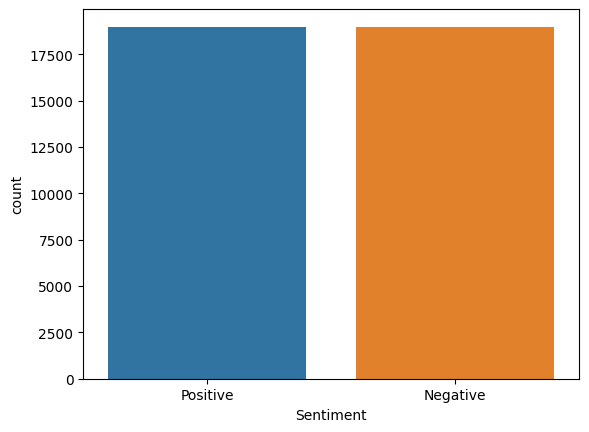

In [ ]:
sns.countplot(x=data[COL_SENTIMENT_NAME])
plt.show()

Z ciekawości wyświetlę też chmurę słów dla poszczególnych klas:

In [ ]:
def BuildWordsCloud(class_type):
  words = ' '.join(data[data[COL_SENTIMENT_NAME] == class_type][COL_TEXT_NAME])
  return WordCloud(max_words=500, width = 1000, height = 600, background_color = 'white', collocations=False).generate(words)

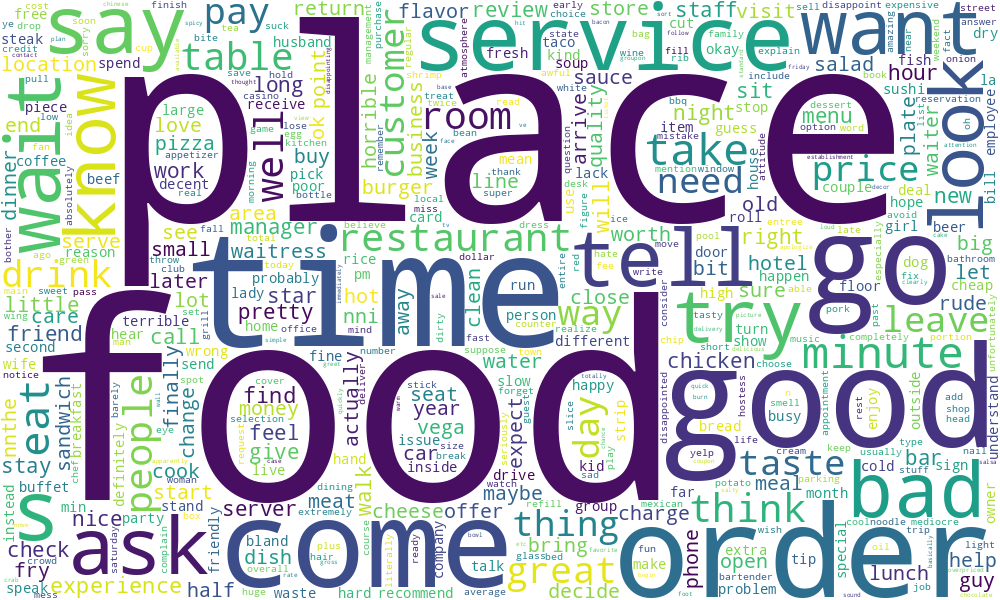

In [ ]:
negative = BuildWordsCloud(SENTIMENT_NEGATIVE_TAG)
negative.to_image()

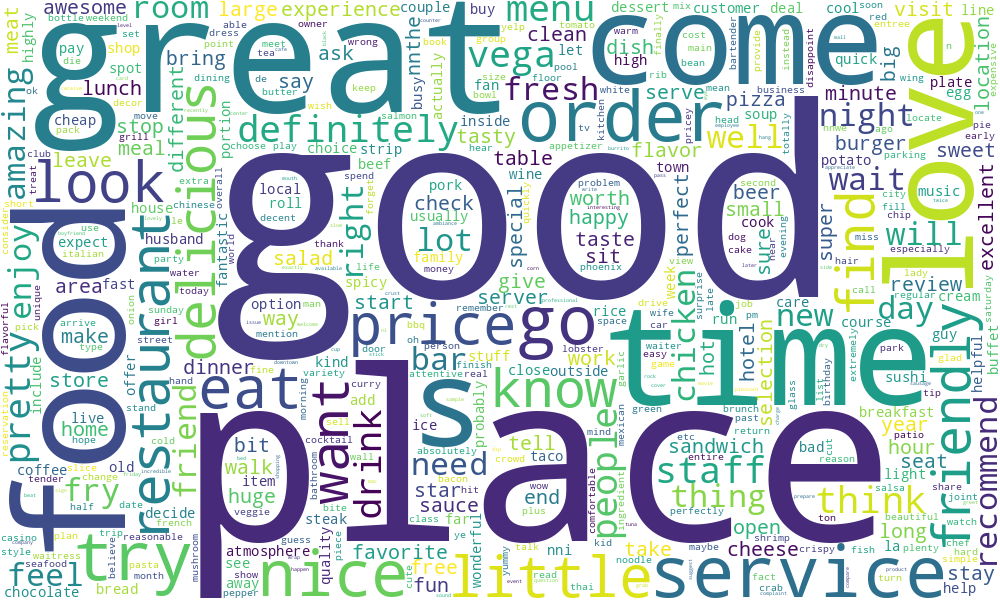

In [ ]:
positive = BuildWordsCloud(SENTIMENT_POSITIVE_TAG)
positive.to_image()

Zapisuję oczyszczone dane do pliku .csv zamieniając wcześniej klasy na wartości 0 i 1

In [ ]:
class_name = {SENTIMENT_NEGATIVE_TAG : 0, SENTIMENT_POSITIVE_TAG : 1}
data[COL_SENTIMENT_NAME] = data[COL_SENTIMENT_NAME].map(class_name)

In [ ]:
CLEANED_DATA_FILENAME = 'cleaned_data.csv'
data.to_csv(DATA_PARENT_DIR + CLEANED_DATA_FILENAME, sep='\t', index=False, header=False)
data[COL_SENTIMENT_NAME] = data[COL_SENTIMENT_NAME].astype(int)

# Przygotowanie Frameworku

Przygotowanie środowiska pytorch: niezbędne importy, ziarno oraz CUDA:

In [ ]:
import torchdata.datapipes as dp
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

Tworzę datapipe'a z oczyszczonego pliku .csv:

In [ ]:
fpath = DATA_PARENT_DIR + CLEANED_DATA_FILENAME
data_pipe = dp.iter.IterableWrapper([fpath])
data_pipe = dp.iter.FileOpener(data_pipe, mode='rb')
data_pipe = data_pipe.parse_csv(skip_lines=0, delimiter='\t', as_tuple=True)

for sample in data_pipe:
  print(sample)
  break


('1', 'contrary review zero complaint service price get tire service past year compare experience place like pep boy guy experience know they be nalso place feel like take advantage gender auto mechanic notorious capitalize ignorance car suck bank account dry service road coverage explain let decide nand renovate wait room look lot well previous year')


Tworzę tokenizer na bazie bibliotaki spacy oraz jego generator:

In [ ]:
tokenizer = get_tokenizer('spacy', 'en_core_web_md')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

Dzielę dane na zbiór testowy i treningowy:

In [ ]:
data_list = list(data_pipe)
random.shuffle(data_list)

split_ratio = 0.8
train_size = int(split_ratio * len(data_list))
train_data = data_list[:train_size]
test_data = data_list[train_size:]

Tworzę słownik:

In [ ]:
MAX_TOKENS = 25000
vocab = build_vocab_from_iterator(yield_tokens(iter(train_data)), specials=['<unk>'], max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

Tworzę potoki tekstu i etykiet:

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == '1' else 0

Tworzę funkcję do przetwarzania danych w batchu:

In [ ]:
def collate_batch(batch):
  label_list, text_list, lenghts = [], [], []

  for (_label, _text) in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    lenghts.append(processed_text.size(0))

  label_list = torch.tensor(label_list, dtype=torch.float32)
  lenghts = torch.tensor(lenghts, dtype=torch.int64)
  text_list = pad_sequence(text_list, batch_first=True)
  return label_list, text_list, lenghts

Tworzę zbiór walidacyjny:

In [ ]:
train_dataset = list(iter(train_data))
test_dataset = list(iter(test_data))

validation_ratio = 0.5
n_test = len(test_dataset)
n_val = int(n_test * validation_ratio)
n_test = n_test - n_val

val_dataset, test_dataset = random_split(test_dataset, [n_val, n_test])

Tworzę dataloader'y do zbioru uczącego, testowego i walidacyjnego:

In [ ]:
BATCH_SIZE = 64

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [ ]:
print(len(val_dataloader))
print(len(test_dataloader))
print(len(train_dataloader))

60
60
475


Tworzę funkcję do trenowania modeli:

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, dataloader, optimizer, criterion, is_cnn = False):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in dataloader:
      labels, texts, lenghts = batch
      texts, labels = texts.to(device), labels.to(device)
      optimizer.zero_grad()
      if is_cnn:
        predictions = model(texts).squeeze(1)
      else:
        predictions = model(texts, lenghts).squeeze(1)

      loss = criterion(predictions, labels)
      acc = binary_accuracy(predictions, labels)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

Tworzę funkcję do oceny jakości modeli:

In [ ]:
def evaluate(_model, _dataloader, _criterion, _is_cnn = False):
    epoch_loss = 0
    epoch_acc = 0
    _model.eval()

    with torch.no_grad():
      for batch in _dataloader:
        labels, texts, lenghts = batch
        texts, labels = texts.to(device), labels.to(device)
        if _is_cnn:
          predictions = _model(texts).squeeze(1)
        else:
          predictions = _model(texts, lenghts).squeeze(1)

        loss = _criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss/len(_dataloader), epoch_acc/len(_dataloader)

Tworzę funkcję do trenowania modeli na epokach:

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_time * 60))
    return elapsed_mins, elapsed_secs

def run_epochs(_model, optimizer):
  N_EPOCHS = 5
  best_valid_loss = float('inf')
  is_cnn = _model.type == NetworkType.CNN
  for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(_model, train_dataloader, optimizer, _model.criterion, is_cnn)
    valid_loss, valid_acc = evaluate(_model, val_dataloader, _model.criterion, is_cnn)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(_model.state_dict(), DATA_PARENT_DIR + _model.output_file)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValidation Loss: {train_loss:.3f} | Validation Acc: {train_acc*100:.2f}%')

Tworzę funkcję do testowania modelu na zbiorze testowym

In [ ]:
def run_on_test_set(model, test_dataset):
  model.load_state_dict(torch.load(DATA_PARENT_DIR + model.output_file))
  test_loss, test_acc = evaluate(model, test_dataset, model.criterion)

  print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Tworzę uwspólnione parametry do inicjalizowania modeli:

In [ ]:
from enum import Enum

class NetworkType(Enum):
  LSTM = 0
  CNN = 1

class NetworkParameters:
  INPUT_DIM = 0
  EMBEDDING_DIM = 0
  HIDDEN_DIM = 0
  N_FILTERS = 0
  N_LAYERS = 0
  FILTER_SIZES = []
  OUTPUT_DIM = 0
  DROPOUT = 0.0
  OPTIMIZER = None
  LOSS_FUNC = None
  EMBEDDING_MATRIX = None
  OUTPUT_FILE = ""
  NETWORK_TYPE = None

Tworzę jedną klasę obejmującą wszystkie modele, tworzoną na podstawie parametrów wejściowych:

In [ ]:
import torch.nn.functional as func

class Network(nn.Module):
    def __init__(self, params):
        super().__init__()

        #
        # Build LSTM
        #
        if params.NETWORK_TYPE == NetworkType.LSTM:
          print("[Network] Creating LSTM model.")
          #
          # LSTM with trainable embedding layer
          #
          if params.EMBEDDING_MATRIX == None:
            print("[Network] Without embedding matrix.")
            self.embedding = nn.Embedding(params.INPUT_DIM, params.EMBEDDING_DIM)
          #
          # LSTM with Pre-Trained Words Embedding
          #
          else:
            print("[Network] With embedding matrix.")
            self.embedding = nn.Embedding.from_pretrained(params.EMBEDDING_MATRIX)

          self.rnn = nn.LSTM(params.EMBEDDING_DIM, params.HIDDEN_DIM, num_layers=params.N_LAYERS, dropout=params.DROPOUT)
          self.fc = nn.Linear(params.HIDDEN_DIM * params.N_LAYERS, params.OUTPUT_DIM)

        #
        # Build CNN
        #
        elif params.NETWORK_TYPE == NetworkType.CNN:
          print("[Network] Creating CNN model")
          self.embedding = nn.Embedding(params.INPUT_DIM, params.EMBEDDING_DIM)
          self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1,
                                                out_channels = params.N_FILTERS,
                                                kernel_size = (fs, params.EMBEDDING_DIM))
                                      for fs in params.FILTER_SIZES])
          self.fc = nn.Linear(len(params.FILTER_SIZES) * params.N_FILTERS, params.OUTPUT_DIM)

        else:
          raise Exception("Unkown network type!")

        #
        # Save shared info
        #
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.criterion = params.LOSS_FUNC.to(device)
        self.dropout = nn.Dropout(params.DROPOUT)
        self.type = params.NETWORK_TYPE
        self.output_file = params.OUTPUT_FILE

    def forward(self, text, text_lengths=[]):
        #
        # LSTM
        #
        if self.type == NetworkType.LSTM:
          embedded = self.embedding(text)
          lengths_clamped = text_lengths.clamp(min=1, max=30000) # Handle cases where lengths is equal to 0.
          packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths_clamped.cpu(), batch_first=True, enforce_sorted=False)
          packed_output, (hidden, cell) = self.rnn(packed_embedded)
          output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
          hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
          return self.fc(hidden.squeeze(0))
        #
        # CNN
        #
        elif self.type == NetworkType.CNN:
          embedded = self.embedding(text)
          embedded = embedded.unsqueeze(1)
          conved = [func.relu(conv(embedded)).squeeze(3) for conv in self.convs]
          pooled = [func.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
          cat = self.dropout(torch.cat(pooled, dim = 1))
          return self.fc(cat)
        else:
          raise Exception("Unkown network type!")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model RNN LSTM

In [ ]:
lstm_params = NetworkParameters()
lstm_params.INPUT_DIM = len(vocab)
lstm_params.EMBEDDING_DIM = 100
lstm_params.HIDDEN_DIM = 256
lstm_params.OUTPUT_DIM = 1
lstm_params.N_LAYERS = 2
lstm_params.DROPOUT = 0.5

lstm_params.LOSS_FUNC = nn.BCEWithLogitsLoss().to(device)
lstm_params.NETWORK_TYPE = NetworkType.LSTM
lstm_params.OUTPUT_FILE = 'lstm_model.pt'

model_lstm = Network(lstm_params).to(device)

[Network] Creating LSTM model.
[Network] Without embedding matrix.


In [ ]:
optimizer = optim.Adam(model_lstm.parameters(), lr=5e-4)
run_epochs(model_lstm, optimizer)

Epoch: 01 | Epoch Time: 0m -1333s
	Train Loss: 0.479 | Train Acc: 76.81%
	Validation Loss: 0.479 | Validation Acc: 76.81%
Epoch: 02 | Epoch Time: 0m -1192s
	Train Loss: 0.334 | Train Acc: 86.15%
	Validation Loss: 0.334 | Validation Acc: 86.15%
Epoch: 03 | Epoch Time: 0m -1151s
	Train Loss: 0.276 | Train Acc: 88.79%
	Validation Loss: 0.276 | Validation Acc: 88.79%
Epoch: 04 | Epoch Time: 0m -1241s
	Train Loss: 0.240 | Train Acc: 90.48%
	Validation Loss: 0.240 | Validation Acc: 90.48%
Epoch: 05 | Epoch Time: 0m -1160s
	Train Loss: 0.200 | Train Acc: 92.28%
	Validation Loss: 0.200 | Validation Acc: 92.28%


In [ ]:
run_on_test_set(model_lstm, test_dataloader)

Test Loss: 0.286 | Test Acc: 88.12%


# Model CNN


In [ ]:
cnn_params = NetworkParameters()
cnn_params.INPUT_DIM = len(vocab)
cnn_params.EMBEDDING_DIM = 100
cnn_params.OUTPUT_DIM = 1
cnn_params.N_FILTERS = 100
cnn_params.FILTER_SIZES = [3,4,5]
cnn_params.DROPOUT = 0.5

cnn_params.LOSS_FUNC = nn.CrossEntropyLoss().to(device)
cnn_params.NETWORK_TYPE = NetworkType.CNN
cnn_params.OUTPUT_FILE = 'cnn_model.pt'

model_cnn = Network(cnn_params).to(device)

[Network] Creating CNN model


In [ ]:
optimizer = optim.Adam(model_cnn.parameters())
run_epochs(model_cnn, optimizer)

Epoch: 01 | Epoch Time: 1m -4790s
	Train Loss: 128.799 | Train Acc: 69.25%
	Validation Loss: 128.799 | Validation Acc: 69.25%
Epoch: 02 | Epoch Time: 1m -4625s
	Train Loss: 124.280 | Train Acc: 80.67%
	Validation Loss: 124.280 | Validation Acc: 80.67%
Epoch: 03 | Epoch Time: 1m -4670s
	Train Loss: 122.689 | Train Acc: 84.38%
	Validation Loss: 122.689 | Validation Acc: 84.38%
Epoch: 04 | Epoch Time: 1m -4888s
	Train Loss: 121.640 | Train Acc: 87.32%
	Validation Loss: 121.640 | Validation Acc: 87.32%
Epoch: 05 | Epoch Time: 1m -4848s
	Train Loss: 120.747 | Train Acc: 89.01%
	Validation Loss: 120.747 | Validation Acc: 89.01%


In [ ]:
run_on_test_set(model_cnn, test_dataloader)

Test Loss: 121.489 | Test Acc: 87.19%


# Model z Pre-Trained Word Embeddings

Ładujemy wektory z GloVe, wersję nauczoną na korpusie 6 miliardów słów z rozmiarami wektorów równymi 100.

In [ ]:
from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.42MB/s]                           
100%|█████████▉| 399999/400000 [00:22<00:00, 17541.17it/s]


Tworzymy macierz embeddingową na bazie wektorów z GloVe i model:

In [ ]:
lstm_words_embed_params = NetworkParameters()
lstm_words_embed_params.INPUT_DIM = len(vocab)
lstm_words_embed_params.EMBEDDING_DIM = 100
lstm_words_embed_params.HIDDEN_DIM = 256
lstm_words_embed_params.OUTPUT_DIM = 1
lstm_words_embed_params.N_LAYERS = 2
lstm_words_embed_params.DROPOUT = 0.5
lstm_words_embed_params.LOSS_FUNC = nn.BCEWithLogitsLoss().to(device)
lstm_words_embed_params.NETWORK_TYPE = NetworkType.LSTM
lstm_words_embed_params.OUTPUT_FILE = 'lstm_words_emved_model.pt'

lstm_words_embed_params.EMBEDDING_MATRIX = torch.zeros((lstm_words_embed_params.INPUT_DIM, lstm_words_embed_params.EMBEDDING_DIM))
for i, word in enumerate(vocab.get_itos()):
    if word in glove.stoi:
        lstm_words_embed_params.EMBEDDING_MATRIX[i] = glove.vectors[glove.stoi[word]]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lstm_words_embed = Network(lstm_words_embed_params).to(device)

[Network] Creating LSTM model.
[Network] With embedding matrix.


In [ ]:
optimizer = optim.Adam(model_lstm_words_embed.parameters(), lr=5e-4)
run_epochs(model_lstm_words_embed, optimizer)

Epoch: 01 | Epoch Time: 0m -1099s
	Train Loss: 0.498 | Train Acc: 76.47%
	Validation Loss: 0.498 | Validation Acc: 76.47%
Epoch: 02 | Epoch Time: 0m -1085s
	Train Loss: 0.399 | Train Acc: 82.87%
	Validation Loss: 0.399 | Validation Acc: 82.87%
Epoch: 03 | Epoch Time: 0m -1108s
	Train Loss: 0.342 | Train Acc: 85.48%
	Validation Loss: 0.342 | Validation Acc: 85.48%
Epoch: 04 | Epoch Time: 0m -1131s
	Train Loss: 0.313 | Train Acc: 86.92%
	Validation Loss: 0.313 | Validation Acc: 86.92%
Epoch: 05 | Epoch Time: 0m -1496s
	Train Loss: 0.283 | Train Acc: 88.51%
	Validation Loss: 0.283 | Validation Acc: 88.51%


In [ ]:
run_on_test_set(model_lstm_words_embed, test_dataloader)

Test Loss: 0.289 | Test Acc: 88.04%


##Funkcja

In [ ]:
def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [vocab[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    if model.type == NetworkType.LSTM:
      length = torch.LongTensor([len(indexed)])
      prediction = torch.round(torch.sigmoid(model(tensor, length)))
    else:
      prediction = torch.round(torch.sigmoid(model(tensor)))
    if prediction.item() == 1.0:
      return "Positive"
    else:
      return "Negative"

In [ ]:
def test_models(text):
  print("====================================")
  print("Input: \"" + text + "\"")
  print("LSTM: " + predict_sentiment(model_lstm, text))
  print("CNN: " + predict_sentiment(model_cnn, text))
  print("LSTM With Word Embedding: " + predict_sentiment(model_lstm_words_embed, text))

test_models("Food is amazing")
test_models("Food is terrible")
test_models("Zero complaint")
test_models("Service was bad")
test_models("The place was outstanding")
test_models("Waiter was rude")
test_models("The dish was delicious")


Input: "Food is amazing"
LSTM: Positive
CNN: Positive
LSTM With Word Embedding: Positive
Input: "Food is terrible"
LSTM: Negative
CNN: Negative
LSTM With Word Embedding: Negative
Input: "Zero complaint"
LSTM: Positive
CNN: Positive
LSTM With Word Embedding: Positive
Input: "Service was bad"
LSTM: Negative
CNN: Negative
LSTM With Word Embedding: Negative
Input: "The place was outstanding"
LSTM: Positive
CNN: Positive
LSTM With Word Embedding: Positive
Input: "Waiter was rude"
LSTM: Negative
CNN: Negative
LSTM With Word Embedding: Negative
Input: "The dish was delicious"
LSTM: Positive
CNN: Positive
LSTM With Word Embedding: Positive
